# Linguistic Analyses for Compositional Abstractions (COSMOS)

*Note: this notebook serves as the instructor version and should be altered to the student version before being presented*

This section is divided into two sections, where each section has multiple parts. **Section 1** covers basic linguistic analyses. **Section 2** covers analyzing referring expressions.

*important to note that students may have to access https://www.nltk.org/data.html to download the NLTK package (Zoe had to do this) & pip install `num2words`*

### Load in Required Packages

In [1]:
## Run this code to load the required packages

import os
import sys
import urllib, io
os.getcwd()

import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import nltk
from nltk.tokenize import RegexpTokenizer

from nltk.corpus import stopwords
stop = stopwords.words('english')

import num2words
from num2words import num2words

# Section 1: Basic Linguistic Analyses

## Part 1.0: Preview the Data

In **Part 1.0** we will preview the data by reading in two different dataframes then examining the structure of them.

**1.0.1** We will begin by reading in two different dataframes:
- `df_chat`: a dataframe that includes our data and the messages that we are interested in examining.
- `df_trial`: a dataframe that includes more data on the accuracy of participants in addition to the messages we are interested in examining.

*Note: Can we define what eventType means?*

In [2]:
# Run this code to read in dataframes from each eventType
df_chat = pd.read_csv('data/df_chat.csv')
df_trial = pd.read_csv('data/df_trial.csv')

**1.0.2** Now, we will remove datasets that didn't meet accuracy threshold (75% accuracy) as a basic preprocessing step before beginning any analyses.

In [42]:
# extract data where there is 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

df75 = df75[df75['trials']>=9]
includedGames = list(df75.reset_index().gameid)

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 49


In [43]:
# exclude the data that did not meet the threshold from analysis
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

**1.0.3** Now, we will preview the data.

In [46]:
# Here is a preview of the df_chat dataframe
df_chat.head()

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,timeElapsedInTurn,timeElapsedInTrial,eventType,practice,individualPracticeAttempts,turnStartTime,trialStartTime,flagged,word_count,char_count
0,0,5ef78389ce2f7f58fcd0a350,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,...,60567,60567,chatMessage,True,NaN,NaN,NaN,False,15,63
1,1,5ef783bace2f7f58fcd0a358,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,...,20018,20018,chatMessage,True,NaN,NaN,NaN,False,13,70
2,2,5ef783e4ce2f7f58fcd0a35e,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,0,...,28166,28166,chatMessage,False,NaN,NaN,NaN,False,9,40
3,3,5ef78401ce2f7f58fcd0a365,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,2,...,21993,57512,chatMessage,False,NaN,NaN,NaN,False,23,99
4,4,5ef7842ace2f7f58fcd0a36e,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,4,...,24789,98193,chatMessage,False,NaN,NaN,NaN,False,17,78


In [47]:
# Here is a preview of the df_trial dataframe
df_trial.head()

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,individualPracticeAttempts,flagged,time_final_block,total_block_duration,total_chat_duration,total_duration,diff,word_count,char_count,n_messages
0,0,5ef783a1ce2f7f58fcd0a354,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5ef783c3ce2f7f58fcd0a35b,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5ef784d6ce2f7f58fcd0a3a0,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,0,...,NaN,False,270221.0,95525.0,163658.0,259183.0,11038.0,106.0,494.0,7.0
3,3,5ef7859cce2f7f58fcd0a3d3,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,C,1.0,0,...,NaN,False,191955.0,63542.0,120868.0,184410.0,7545.0,88.0,421.0,6.0
4,4,5ef7863ece2f7f58fcd0a405,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,Pi,2.0,0,...,NaN,False,157681.0,67865.0,87195.0,155060.0,2621.0,58.0,257.0,3.0


## Part 1.1: Word Count and Character Count Linguistic Analyses

In **Part 1.1**, we will be conducting some basic linguistic analyses to understand more about our data and the messages that make up the data. The goal of this part is to get a better understanding of both the **word count** and **character count** of these messages, and how these counts changed across trials.

**1.1.1** We will begin by creating 2 columns in the `df_chat` dataframe. 1 column will be for the word count of the messages and the other column will be for the character count of the messages.

In [5]:
# create a column for word count
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()

# create a column for character count
df_chat['char_count'] = df_chat['content'].str.len()

**1.1.2** We will now add the **word count** and **character count** values to the `df_trial` dataframe, which we will use for plotting these distributions at the end of this part.

In [6]:
# df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

# add word count and character count to df_trial dataframe
trial_sums = df_chat[['gameid','trialNum','word_count','char_count']].groupby(['gameid','trialNum']).sum().reset_index()
df_trial = df_trial.merge(trial_sums, how='outer',on=['gameid','trialNum'])

**1.1.3** Finally, we will count the number of messages that were sent by using the `df_chat` dataframe. We will then add this number to the `df_trial` dataframe.

In [ ]:
# message counts
counts = df_chat.groupby(['gameid','trialNum'])[['iterationName']].count().reset_index()\
    .rename(columns={'iterationName':'n_messages'})
df_trial = df_trial.merge(counts, how='left', on=['gameid','trialNum'])

### Part 1.2: Visualizing Word Count and Character Count

We just conducted some basic linguistic analyses. Now, in **Part 1.2**,  will visualize the analyses we just completed. The following plots shows the distribution of the mean word count and mean character count so that we can understand how these counts change across repetition.

**1.2.1** Here, we are first finding the mean for each repetition.

In [ ]:
# group by repNum and create means
repNum_grouped = df_trial.groupby('repNum')
means = repNum_grouped.mean()

**1.2.2** Here, we are plotting **word count** over repetitions.

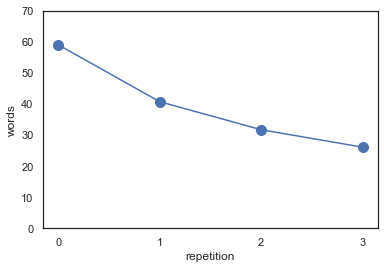

In [41]:
# plot word count over repetitions
repNum_grouped = df_trial.groupby('repNum')
means = repNum_grouped.mean()

plt.plot(means['word_count'], linestyle='-', marker='o', markersize=10)
plt.xlabel('repetition')
plt.ylabel('words')
#plt.xlim(0.5, 4.5)
plt.ylim(0, 70)
plt.show()

**1.2.3** Here we are plotting **character count** over reptitions.

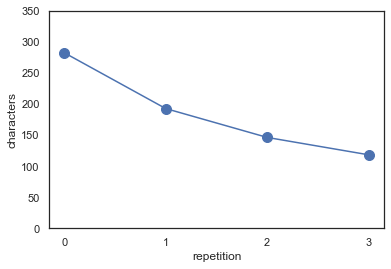

In [40]:
# plot char count over repetitions
plt.plot(means['char_count'], linestyle='-', marker='o', markersize=10)
plt.xlabel('repetition')
plt.ylabel('characters')
#plt.xlim(0.75, 4.25)
plt.ylim(0, 350)
plt.show()

# Section 2: Analyzing Referring Expressions 

While our analyses so far tell us about language use in general, we're primarily interested in how the expressions used to refer to certain entities in our experiment change over time. In particular, we want to know when people transition from providing instructions about lower-level, block by block placements, to higher-level tower abstractions. While we could in principle use NLP techniques to extract noun phrases and assess their meaning, people might use a wide variety of expressions to refer to blocks and towers.  

Because of this, we asked naive raters to **identify the referring expressions** used in each message, as well as the **number of abstractions at each level (block vs. tower)**. In **Section 2**, we will analyze these referring expressions.

## Part 2.1: Preview the Data

First, we will load in these referring expression annotations that were completed by the naive raters.

In [48]:
# Run this code to read in the referring expressions dataframe
df_ref_exps = pd.read_csv('data/df_ref_exps.csv')

*Note to anonymize `workerID` before presenting this notebook*

#### Here is a preview of the `df_ref_exps` dataframe, which includes the referring expressions annotations:

In [9]:
# Run this code to preview the df_ref_exps dataframe
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1


**2.1.1** Here, the goal is to preview the referring expressions that were identified by the raters. We are particularly interested in the `message`, `content`, `block`, and `tower` columns to do this.

In [10]:
# Edit this code to look at the collection of referring expressions identified by raters
df_ref_exps[['message','content','block','tower']].head()

,message,content,block,tower
0,two blue blocks on left and right side of left...,two blue,2,0
1,two blue blocks on left and right side of left...,two blue blocks,2,0
2,two red block on top of left blue block just p...,two red,2,0
3,two red block on top of left blue block just p...,two red block,2,0
4,two red block one space apart on right line,two red,2,0


**2.1.2** Here we want to convert the `content` column to be of type "string."

In [49]:
# Edit this code to conver the content column to be type string
df_ref_exps.loc[:,'content'] = df_ref_exps.loc[:,'content'].astype(str)

## Part 2.2: Data Preprocessing

Now, we will preprocess the referring expressions dataframe. We have 3 goals in this section:
1. **Remove Stop Words**: Stop words are XXX. In analyzing these referring expressions, the stop words make no difference to our analyses, therefore we want to remove them so as to not add extra noise.
2. **Convert Number Words**: Number words are words that are used instead of numbers. For example, if someone said "two" instead of using the number 2. We want to convert these number words to numbers because the difference between these words and the actual numbers does not matter in our case for analysis.
3. **Lemmatize Words**: Lemmatizing words means sorting or grouping words so as to obtain the stem of the word. For example, we want the phrases *"two blue block"* and *"two blue blocks"* to be treated the same. To do this, we must convert words into their stem word.

Each of these three goals are seen as separate problems below. Please go through each step in order, and read the detailed instructions for that goal before beginning.

It is important to note that there exists NLP processing libraries that can be used when preprocessing data. To execute our 3 goals listed above, we will be using `NLTK`, which stands for "Natural Language Toolkit." We downloaded this package in the beginning of the notebook.

### Goal 1: Remove Stop Words

**2.2.1** First, we will begin by **removing stop words**.

In [12]:
# remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_ref_exps['content'].head()

0           two blue
1    two blue blocks
2            two red
3      two red block
4            two red
Name: content, dtype: object

### Goal 2: Convert Number Words

**2.2.2** Next, we will **convert number words**.

In [13]:
# convert number words

def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: num_2_words(x))

### Goal 3: Lemmatize Words

**2.2.3** Our final step will be to **lemmatize words**.

In [14]:
# lemmatize

tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

df_ref_exps['BOW_lemmatized'] = df_ref_exps['content'].apply(lemmatize_text)
df_ref_exps['BOW_lemmatized'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: [i.upper() for i in x])

df_ref_exps[['message','content','BOW_lemmatized']].head()

,message,content,BOW_lemmatized
0,two blue blocks on left and right side of left...,two blue,"[TWO, BLUE]"
1,two blue blocks on left and right side of left...,two blue blocks,"[TWO, BLUE, BLOCK]"
2,two red block on top of left blue block just p...,two red,"[TWO, RED]"
3,two red block on top of left blue block just p...,two red block,"[TWO, RED, BLOCK]"
4,two red block one space apart on right line,two red,"[TWO, RED]"


In [15]:
df_ref_exps['word_freq'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: Counter(x))
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep,BOW_lemmatized,word_freq
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1,"[TWO, BLUE]","{'TWO': 1, 'BLUE': 1}"
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1,"[TWO, BLUE, BLOCK]","{'TWO': 1, 'BLUE': 1, 'BLOCK': 1}"
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1,"[TWO, RED, BLOCK]","{'TWO': 1, 'RED': 1, 'BLOCK': 1}"
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"


In [16]:
df_ref_exps['BOW_concat'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: ' '.join(x))

## Part 2.3: Creating Distributions of Words

In Part **2.3**, the goal is to create distributions of words. We will start this process by converting word counts to proportions of words. More specifically, in this step, we will we want to convert the amount of times a word is repeated to a probability distribution. We will then see how the porportion of words changes between trials. Our final goal is to plot this data to understand how these word frequencies change throughout trials.

### First, we will begin by converting our word counts to proportions.

**2.3.1** Here, our goal is to convert the word frequencies to proportions. Currently, the word counts represent the counts from all 4 of our naive raters. So that we can examine how frequently different words were used, we need to convert these values into proportions.

In [17]:
# create support
split_words = df_ref_exps['BOW_concat'].apply(lambda x: x.split())
all_words = list(pd.Series([st for row in split_words for st in row]).unique())
support = {}
for word in all_words:
    support[word] = 0.000000001
    
def get_pdist(row):
    num_words = np.sum(list(row['word_freq'].values()))
    pdist = support.copy()
    for i, (word, count) in enumerate(row['word_freq'].items()):
        pdist[word] = count/num_words
    return pdist

In [18]:
df_ref_exps['word_pdist'] = df_ref_exps.apply(get_pdist, axis = 1)
df_ref_exps['word_pdist_numeric'] = df_ref_exps['word_pdist'].apply(lambda dist: list(dist.values()))

In [19]:
df_all_words = df_ref_exps[['dyad_gameid', 'rep', 'BOW_concat']]

In [20]:
for w in all_words:
    df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))

/Users/zoetait/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/zoetait/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [21]:
df_all_words_reps = df_all_words.groupby('rep').agg(sum)
df_all_words_reps

,TWO,BLUE,BLOCK,RED,ONE,EXACT,CONSTRUCTION,LEFT,RIGHT,SIDE,...,OUSE,TILE,BLOC,SHAP,HORIZTONAL,MAKE,ANGLE,CENTRED,LEFTMOST,TWR
rep,,,,,,,,,,,,,,,,,,,,,
1,623,1085,1100,1035,224,0,0,3,5,9,...,0,3,1,0,2,1,1,1,0,0
2,512,1129,499,979,184,5,3,11,10,13,...,0,0,0,1,0,0,0,0,1,1
3,320,868,181,777,131,0,0,5,7,7,...,1,1,0,0,0,0,0,0,0,0
4,75,209,35,184,20,0,0,2,1,2,...,0,0,0,0,0,0,0,0,0,0


### Now, we will examine the change in word frequencies between trials.

**2.3.2** We will begin by preparing our data.

In [22]:
df_ref_exps_rep = df_ref_exps.groupby('rep')['BOW_concat'].apply(lambda group:' '.join(group)).reset_index()
df_ref_exps_rep['word_freq'] = df_ref_exps_rep['BOW_concat'].apply(lambda x: Counter(x.split()))
df_ref_exps_rep['word_pdist'] = df_ref_exps_rep.apply(get_pdist, axis=1)
df_ref_exps_rep['word_pdist_numeric'] = df_ref_exps_rep['word_pdist'].apply(lambda dist: list(dist.values()))
df_ref_exps_rep.index=df_ref_exps_rep['rep']

**2.3.3** We will now calculate the difference in how frequently words were used between trials by calculating the difference between proportions between trials.

In [23]:
# calculate difference in proportion between reps

rep_a = 1
rep_b = 4

rep_diff = {}

for _, (k, rep_a_v) in enumerate(df_ref_exps_rep.loc[rep_a,'word_pdist'].items()):
    rep_diff[k] = df_ref_exps_rep.loc[rep_b,'word_pdist'][k] - rep_a_v

**2.3.4** Now, we will find the top 6 words that have the largest increase in word frequency between trials.

In [24]:
# find largest n increase/ decrease in proportion across reps
n = 6

In [25]:
# find the largest increase in proportion between reps
top_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=True)[:n])

top_n

{'L': 0.05734655611812832,
 'C': 0.03298536181665175,
 'SHAPE': 0.032698562616607654,
 'BLUE': 0.02154686921943194,
 'U': 0.020250494326782383,
 'TALL': 0.01816359509904137}

**2.3.5** Now, we will find the top 6 words that have the largest decrease in word frequency between trials.

In [26]:
# find the largest decrease in proportion between reps

bottom_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=False)[:n])

bottom_n

{'BLOCK': -0.15443041001392815,
 'TWO': -0.03777088343850854,
 'HORIZONTAL': -0.02285785639184289,
 'ONE': -0.01672335567019553,
 'VERTICAL': -0.01624128327697643,
 'RED': -0.009534645383217022}

In [27]:
df_grouped = df_ref_exps.groupby('rep').agg({'BOW_lemmatized': 'sum'})

### Now, we will plot this change in word frequency.

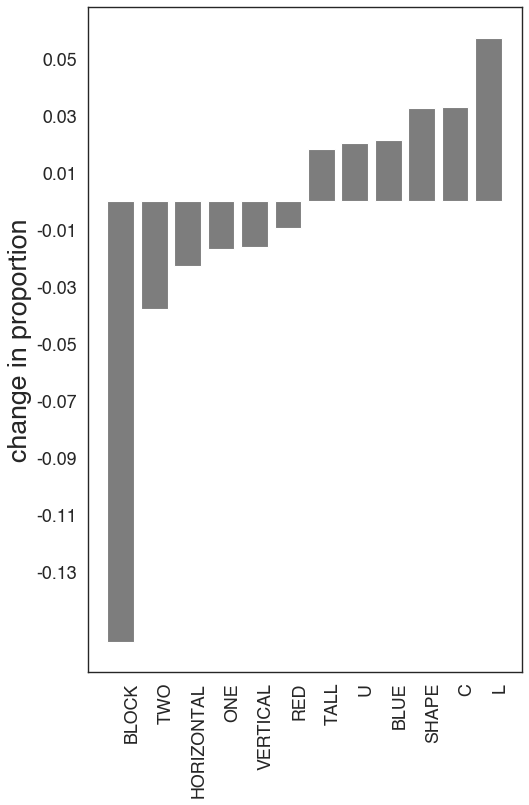

In [28]:
from matplotlib.ticker import FormatStrFormatter

font = {'fontname':'Helvetica'}
sns.set_theme(style='white')

x_limit = 6

labels, values = zip(*rep_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange your data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))

bar_width = 0.35

fig = plt.figure(num=None, figsize=(7, 11), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.bar(indexes, values, color = "#7D7D7D")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# add labels
plt.yticks(fontsize=16, **font)
plt.xticks(indexes + bar_width, labels,  rotation='vertical', fontsize=16, **font)
plt.ylabel("change in proportion", size = 24, **font)
plt.yticks(np.arange(-.13,.06, .02))
ax.axes.get_xaxis().set_visible(True)
#plt.title("highest delta words", size = 24, **font)
plt.show()